In [21]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb

### Internal Classes
from testing import Tester

In [22]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN')

In [23]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: Environment variable`H

In [24]:
openai = OpenAI()

In [25]:
with open("test.pkl", "rb") as f: 
    test = pickle.load(f)

In [26]:
DB = "products_vectorstore/"

client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection("product")

In [27]:
embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

In [ ]:
test[0].test_prompt()

In [28]:
def description(item):
    text = item.prompt.replace("How much does this cost to the nearest dollar?\n\n", "")
    return text.split("\n\nPrice is $")[0]

In [29]:
def vector(item): 
    return embedding_model.encode([description(item)])

In [30]:
def find_similars(item): 
    results = collection.query(query_embeddings=vector(item))
    similar_docs = results["documents"][0][:]
    prices = [meta["price"] for meta in results["metadatas"][0][:]]
    
    return similar_docs, prices 

In [13]:
find_similars(test[1])

(['Main_Category: Tools & Home Improvement\n\nPorlik 8 Inch Heavy Duty Metal Peg Board Shelving Hooks, Seven-Station Waterfall Hook, Pegboard Hook Steel Stainless Hooks Pegs Duty，Heavy Control Wall Hangers，Heavy Duty Pegboard Pack\nThese hooks are a simple yet brilliant storage solution for any kitchen or work area where space is limited and you might need to something up. These hooks are made of stainless steel which is strong and safe, so you can heavier items without fear of them falling or becoming damaged. Material  Stainless Steel. - Take little space for hanging displaying goods or tools, easy to install and use. - for hanging tools, brushes, extension cables, sports equipment, etc., to make your room more concise and tidy. - Hooks used for grid wall brackets to make your products great cube displaying. - ',
  'Main_Category: Tools & Home Improvement\n\nFactorDuty 200 Pack 2 inch Length Steel Black PEG Board Pegboard Shelving Hooks Wholesale Lot 20 lbs PEG Hooks Organizer Tools 

In [31]:
def make_context(similars, prices): 
    message = "To provide some context, here are some other items that might be similar to the item you need to estimate.\n\n"
    for similar, price in zip(similars, prices): 
        message += f"Potentially related product:\n{similar}\nPrice is ${price:.2f}\n\n"
    
    return message

In [32]:
def messages_for(item, similars, prices): 
    system_message = "You estimate prices of items. Reply only with the price, no explanation."
    user_prompt = make_context(similars, prices)
    user_prompt += "And now the question for you:\n\n"  
    user_prompt += item.test_prompt().replace("to the nearest dollar", "").replace("Price is $", "")
    
    return [
        {"role": "system", "content": system_message}, 
        {"role": "user", "content": user_prompt}, 
        {"role": "assistant", "content": "Price is $"}
    ]

In [ ]:
docs, prices = find_similars(test[2])

In [ ]:
print(test[2])

In [ ]:
print(make_context(docs, prices))

In [ ]:
print(messages_for(test[5], docs, prices)[1]["content"])

In [33]:
def get_price(s): 
    s = s.replace("$", "").replace(",", "")
    match = re.search(r"[-+]?\d*.\d+|\d+", s)
    return float(match.group()) if match else 0

In [34]:
def gpt_5_mini_rag(item): 
    documents, prices = find_similars(item)
    response = openai.chat.completions.create(
        model="gpt-5-mini", 
        messages=messages_for(item, documents, prices), 
        seed=42
    )
    reply = response.choices[0].message.content 
    return get_price(reply)

In [35]:
test[500].price

139.37

In [36]:
gpt_5_mini_rag(test[500]) 

229.99

## Evaluate the GPT 5-mini with RAG system

1: Guess: $174.95 Truth: $249.99 Error: $75.04 SLE: 0.13 Item: Medicom Batman Hush Black Suit Version B...
2: Guess: $9.99 Truth: $3.99 Error: $6.00 SLE: 0.62 Item: ALTKOL S Hooks for Hanging, 15-Pack S Sh...
3: Guess: $99.00 Truth: $109.99 Error: $10.99 SLE: 0.01 Item: Nady RSM-5 Ribbon Microphone - Unique co...
4: Guess: $9.99 Truth: $6.97 Error: $3.02 SLE: 0.10 Item: PANDAFLY Acrylic Paint Pens for Rock Pai...
5: Guess: $129.99 Truth: $164.99 Error: $35.00 SLE: 0.06 Item: Mistel MD600RGB v3 60% Split Mechanical ...
6: Guess: $34.99 Truth: $204.00 Error: $169.01 SLE: 3.03 Item: SWITCH by Design Studio, Big Giant Plaid...
7: Guess: $159.00 Truth: $168.00 Error: $9.00 SLE: 0.00 Item: Polk Audio - A Pair of DB652 6.5" Coaxia...
8: Guess: $24.99 Truth: $15.00 Error: $9.99 SLE: 0.24 Item: 6 Pack of 2 Inch Acoustic Foam Panels- P...
9: Guess: $429.00 Truth: $378.32 Error: $50.68 SLE: 0.02 Item: Guild Guitars Jumbo Jr Mahogany Acoustic...
10: Guess: $89.99 Truth: $122.55 Error: $32.56 SLE: 

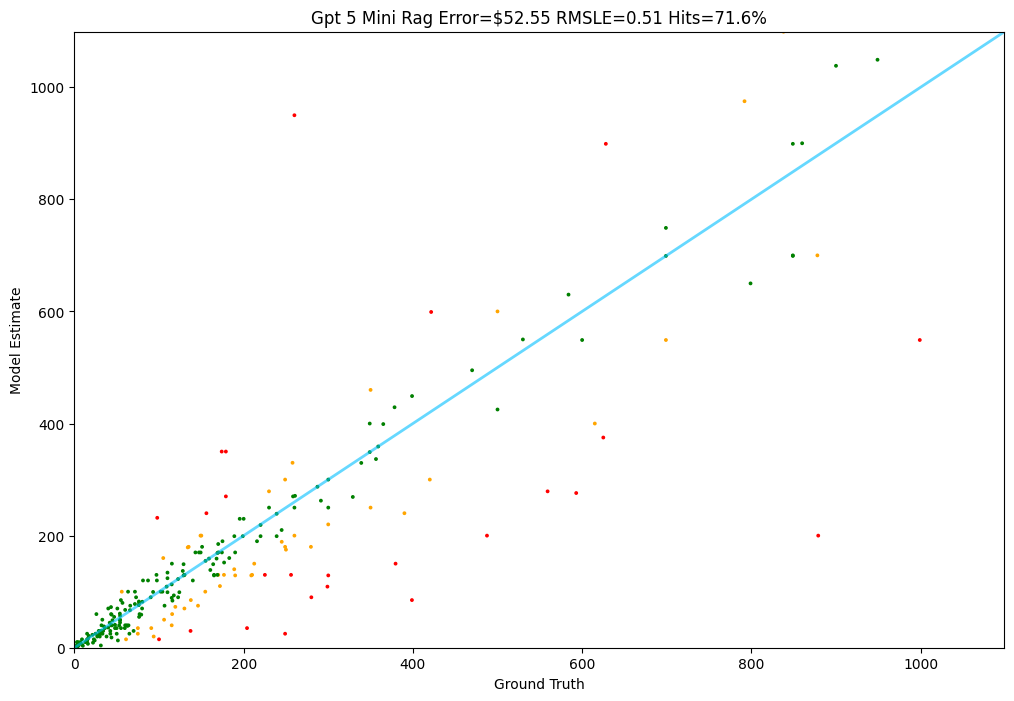

In [39]:
Tester.test(gpt_5_mini_rag, test[:250])